<a href="https://colab.research.google.com/github/tengkumuazabs/my-portfolio/blob/main/thesis/Hybrid_CNN_for_COVID_19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import cv2
import pandas as pd
import os
import shutil
import seaborn as sns
from sklearn import svm
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, precision_score, f1_score, recall_score, classification_report, mean_absolute_error, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, KFold,StratifiedKFold
from sklearn import preprocessing
from sklearn.preprocessing import label_binarize
import random
from keras.models import Model, Sequential
from keras.applications import InceptionV3, InceptionResNetV2, MobileNetV2, ResNet50, ResNet101, DenseNet201, DenseNet121, EfficientNetB0, VGG16, Xception, MobileNet, EfficientNetB2, Xception, InceptionResNetV2
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
from keras.layers import Dense, Dropout, Input
from keras.utils import to_categorical
import pickle

In [ ]:
images_original, images_clahe, images_he, images_comp, images_bcet, images_gamma = [], [], [], [], [] ,[]
labels_original, labels_clahe, labels_he, labels_comp, labels_bcet, labels_gamma = [], [], [], [], [], []

def append_img(images, labels, img_type):
  img_class = [0, 1]
  for img_class in img_class:
    for index, img_path in enumerate(sorted(glob.glob('Thesis/colab images/{}/{}/*'.format(img_type, img_class)))):
      img = cv2.imread(img_path)
      images.append(img)
      labels.append(img_class)
      if index == 24:
        break

append_img(images_original, labels_original, 'original')
append_img(images_clahe, labels_clahe, 'clahe')
append_img(images_he, labels_he, 'he')
append_img(images_comp, labels_comp, 'comp')
append_img(images_bcet, labels_bcet, 'bcet')
append_img(images_gamma, labels_gamma, 'gamma')

In [ ]:
len(labels_original)

50

In [ ]:
# Comparing images side by side
w = random.randrange(0, 20)

print(w)
print(labels_clahe[w])


f, axarr = plt.subplots(2,3)

axarr[0, 0].imshow(images_he[w], cmap='gray')
axarr[0, 1].imshow(images_clahe[w], cmap='gray')
axarr[0, 1].imshow(images_he[w], cmap='gray')
axarr[1, 0].imshow(images_comp[w], cmap='gray')
axarr[1, 1].imshow(images_bcet[w], cmap='gray')
axarr[1, 2].imshow(images_gamma[w], cmap='gray')

In [ ]:
SIZE = 224

In [ ]:
# Loading pretrained network
inceptionv3 = InceptionV3(weights=None, include_top=False, input_shape=(SIZE, SIZE, 3))
inceptionv3.load_weights('Thesis/Inception_224_up_uncrop.h5', skip_mismatch=True, by_name=True)

efficientnetb2 = EfficientNetB2(weights=None, include_top=False, input_shape=(SIZE, SIZE, 3))
efficientnetb2.load_weights('Thesis/EfficientNet_224_up_uncrop.h5', skip_mismatch=True, by_name=True)

resnet50 = ResNet50(weights=None, include_top=False, input_shape=(SIZE, SIZE, 3))
resnet50.load_weights('Thesis/ResNet50_224_up_uncrop.h5', skip_mismatch=True, by_name=True)

densenet121 = DenseNet121(weights=None, include_top=False, input_shape=(SIZE, SIZE, 3))
densenet121.load_weights('Thesis/DenseNet_224_up_uncrop.h5', skip_mismatch=True, by_name=True)

xception = Xception(weights=None, include_top=False, input_shape=(SIZE, SIZE, 3))
xception.load_weights('Thesis/Xception_224_up_uncrop.h5', skip_mismatch=True, by_name=True)

inceptionresnet = InceptionResNetV2(weights=None, include_top=False, input_shape=(SIZE, SIZE, 3))
inceptionresnet.load_weights('Thesis/InceptionResNet_224_up_uncrop.h5', skip_mismatch=True, by_name=True)

In [ ]:
cnn_models = [inceptionv3, efficientnetb2, densenet121, resnet50, xception, inceptionresnet]

In [ ]:
ml_models = [KNeighborsClassifier(), svm.SVC(probability=True)]

In [ ]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

In [ ]:
acc, precision, recall, f1, tprs, fprs, aucs, scores = [], [], [], [], [], [], [], []
report_original, report_clahe = pd.DataFrame(), pd.DataFrame()

In [ ]:
# From pixel scaling to performance reporting
def cv_algorithms(clf, images, labels, model):
    global acc, precision, recall, f1, tprs, fprs, aucs, report

    cv_no = 1

    images = np.array(images)
    labels = np.array(labels)

    images = images / 255.0

    images_extract = model.predict(images)
    images_features = images_extract.reshape(images_extract.shape[0], -1)

    pca = PCA(n_components=0.95)
    images_features_pca = pca.fit_transform(images_features)

    for train_index, test_index in kfold.split(images_features_pca, labels):

        X_train, X_test = images_features_pca[train_index], images_features_pca[test_index]
        y_train, y_test = labels[train_index], labels[test_index]

        clf = clf

        clf.fit(X_train, y_train.flatten())

        prediction = clf.predict(X_test)

        a = accuracy_score(y_test, prediction)
        p = precision_score(y_test, prediction)
        r = recall_score(y_test, prediction)
        f = f1_score(y_test, prediction)

        acc.append(f"{a:.{3}f}")
        precision.append(f"{p:.{3}f}")
        recall.append(f"{r:.{3}f}")
        f1.append(f"{f:.{3}f}")

        prediction_proba = clf.predict_proba(X_test)[:,1]

        mean_fpr = np.linspace(0, 1, 100)
        fpr, tpr, thresholds = roc_curve(y_test, prediction_proba)
        tprs.append(np.interp(mean_fpr, fpr, tpr))

        auc_score = roc_auc_score(y_test, prediction_proba)
        aucs.append(f"{auc_score:.{3}f}")

        cv_no += 1

    acc = np.array(acc, dtype=np.float32)
    precision = np.array(precision, dtype=np.float32)
    recall = np.array(recall, dtype=np.float32)
    f1 = np.array(f1, dtype=np.float32)
    aucs = np.array(aucs, dtype=np.float32)

    tprs_mean = np.mean(tprs, axis=0)
    tprs_std = np.std(tprs, axis=0)
    roc_auc_mean = np.mean(aucs)
    roc_auc_std = np.std(aucs)

    new_row = {
        "model": model.name, "clf": clf, "acc": np.mean(acc), "precision": np.mean(precision), "recall": np.mean(recall), "f1": np.mean(f1), "auc": np.mean(aucs)
      }

    report = pd.concat([report, pd.DataFrame([new_row])])

    acc, precision, recall, f1, tprs, fprs, aucs, scores = [], [], [], [], [], [], [],[]

    return report

In [ ]:
def predict(cnn, ml, images, labels, report_type):
  for i in cnn:
    for j in ml:
      cv_algorithms(j, images, labels, i)
  return report

In [ ]:
report = pd.DataFrame()
report_original = predict(cnn_models, ml_models, images_original, labels_original, report_original)

27/27 [==============================] - 41s 2s/step


In [ ]:
report = pd.DataFrame()
report_clahe = predict(cnn_models, ml_models, images_clahe, labels_clahe, report_clahe)

27/27 [==============================] - 42s 2s/step


In [ ]:
report_original.to_csv('Thesis/report/report_original.csv')

In [ ]:
report_clahe.to_csv('Thesis/report/report_clahe.csv')

In [ ]:
df_original = pd.read_csv('Thesis/report/report_original.csv').drop('Unnamed: 0', axis=1)

In [ ]:
def to_percentage(col):
  return col.transform(lambda x: '{:,.2%}'.format(x))

In [ ]:
df[['acc', 'precision', 'recall', 'f1', 'auc']] = df[['acc', 'precision', 'recall', 'f1', 'auc']].apply(to_percentage, axis=1)

,model,clf,acc,precision,recall,f1,auc
0,inception_v3,KNeighborsClassifier(),60.90%,71.88%,35.68%,47.60%,64.94%
1,inception_v3,SVC(probability=True),72.66%,73.42%,71.34%,72.26%,78.00%
2,efficientnetb2,KNeighborsClassifier(),55.86%,56.06%,53.54%,54.68%,59.38%
3,efficientnetb2,SVC(probability=True),58.92%,58.92%,59.92%,59.30%,62.20%
4,densenet121,KNeighborsClassifier(),71.38%,74.64%,65.42%,69.58%,75.86%
5,densenet121,SVC(probability=True),74.54%,77.12%,69.84%,73.22%,80.64%
6,resnet50,KNeighborsClassifier(),62.20%,76.72%,35.92%,48.30%,67.64%
7,resnet50,SVC(probability=True),72.64%,73.62%,71.08%,72.16%,80.60%
8,xception,KNeighborsClassifier(),55.28%,56.58%,45.28%,50.14%,55.26%
9,xception,SVC(probability=True),60.54%,60.26%,61.34%,60.74%,65.28%


In [ ]:
df_clahe = pd.read_csv('Thesis/report/report_clahe.csv').drop('Unnamed: 0', axis=1)

In [ ]:
df_clahe[['acc', 'precision', 'recall', 'f1', 'auc']] = df_clahe[['acc', 'precision', 'recall', 'f1', 'auc']].apply(to_percentage, axis=1)

In [ ]:
df_clahe

,model,clf,acc,precision,recall,f1,auc
0,inception_v3,KNeighborsClassifier(),67.26%,67.34%,66.54%,66.90%,71.30%
1,inception_v3,SVC(probability=True),73.70%,76.52%,69.30%,72.52%,79.98%
2,efficientnetb2,KNeighborsClassifier(),60.44%,61.34%,57.14%,59.06%,62.58%
3,efficientnetb2,SVC(probability=True),60.44%,68.50%,38.50%,49.22%,65.90%
4,densenet121,KNeighborsClassifier(),69.94%,70.22%,68.88%,69.52%,76.32%
5,densenet121,SVC(probability=True),74.76%,76.62%,71.24%,73.80%,81.72%
6,resnet50,KNeighborsClassifier(),58.10%,74.24%,25.08%,37.30%,63.52%
7,resnet50,SVC(probability=True),75.10%,77.90%,71.16%,74.12%,81.84%
8,xception,KNeighborsClassifier(),51.64%,62.48%,8.20%,14.42%,51.68%
9,xception,SVC(probability=True),52.24%,65.48%,9.16%,16.04%,48.34%


In [ ]:
report_clahe.auc * 100 - report_original.auc * 100

0     6.359993
0     1.979996
0     3.200008
0     3.700005
0     0.459991
0     1.080002
0    -4.119995
0     1.240013
0    -3.579998
0   -16.939999
0    -4.699997
0    -0.960007
Name: auc, dtype: float32

In [ ]:
# using clahe can improve several hybrid models

In [ ]:
def save_model(cnn, ml, images, labels, img_type):
    images = np.array(images)
    labels = np.array(labels)

    images = images / 255.0

    images_extract = cnn.predict(images)
    images_features = images_extract.reshape(images_extract.shape[0], -1)

    ml.fit(images_features, labels.flatten())

    pickle.dump(ml, open(img_type + '_' + cnn.name + '_' + str(ml), "wb"))

In [ ]:
save_model(inceptionv3, svm.SVC(kernel='linear', probability=True), images_original, labels_original, 'original')
save_model(inceptionv3, svm.SVC(kernel='linear', probability=True), images_clahe, labels_clahe, 'clahe')

27/27 [==============================] - 21s 781ms/step


In [ ]:
save_model(resnet50, svm.SVC(kernel='linear', probability=True), images_original, labels_original, 'original')
save_model(resnet50, svm.SVC(kernel='linear', probability=True), images_clahe, labels_clahe, 'clahe')

27/27 [==============================] - 33s 1s/step


In [ ]:
save_model(resnet50, svm.SVC(probability=True), images_original, labels_original, 'original')
save_model(resnet50, svm.SVC(probability=True), images_clahe, labels_clahe, 'clahe')

27/27 [==============================] - 32s 1s/step


In [8]:
# # Group images by findings
# metadata = pd.read_csv(r'test images\Actualmed-COVID-chestxray-dataset\metadata.csv')

# if os.path.exists(r'test images\Actualmed-COVID-chestxray-dataset\categories\No Finding') == False:
#     os.makedirs(r'test images\Actualmed-COVID-chestxray-dataset\categories\No Finding')
# if os.path.exists(r'test images\Actualmed-COVID-chestxray-dataset\categories\COVID-19') == False:
#     os.makedirs(r'test images\Actualmed-COVID-chestxray-dataset\categories\COVID-19')

# from_folder = r'test images\Actualmed-COVID-chestxray-dataset\images'
# no_finding_folder = r'test images\Actualmed-COVID-chestxray-dataset\categories\No Finding'
# covid_folder = r'test images\Actualmed-COVID-chestxray-dataset\categories\COVID-19'

# for index in metadata.index.values:
#     img_name = metadata.iloc[index]['imagename']
#     keyword = metadata.iloc[index]['finding']
#     img = cv2.imread(from_folder + '/' + img_name)
#     img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
#     if keyword == 'No finding':
#         cv2.imwrite(os.path.join(no_finding_folder, img_name), img)
#     elif keyword == 'COVID-19':
#         cv2.imwrite(os.path.join(covid_folder, img_name), img)

In [ ]:
images_test_original, images_test_clahe = [], []
labels_test_original, labels_test_clahe = [], []

In [ ]:
for directory_path in sorted(glob.glob('Thesis/test images/Actualmed-COVID-chestxray-dataset-master/categories/*')):
    label = directory_path.split("\\")[-1]
    for img_path in glob.glob(os.path.join(directory_path, '*.png')):
        img = cv2.imread(img_path)
        img = cv2.resize(img, (SIZE, SIZE), interpolation=cv2.INTER_AREA)
        images_test_original.append(img)
        labels_test_original.append(label)

for img_path in sorted(glob.glob('Thesis/test images/covid-19-image-repository-master/png/*'))[0:180]:
    img = cv2.imread(img_path)
    img = cv2.resize(img, (SIZE, SIZE))
    images_test_original.append(img)
    labels_test_original.append('COVID-19')

images_test_original = np.array(images_test_original)
images_test_original = np.array(images_test_original)
labels_test_original = label_binarize(labels_test_original, classes = ['No Finding', 'COVID-19'])

In [ ]:
clahe = cv2.createCLAHE()

for directory_path in sorted(glob.glob('Thesis/test images/Actualmed-COVID-chestxray-dataset-master/categories/*')):
    label = directory_path.split("\\")[-1]
    for img_path in glob.glob(os.path.join(directory_path, '*.png')):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = clahe.apply(img)
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        img = cv2.resize(img, (SIZE, SIZE), interpolation=cv2.INTER_AREA)
        images_test_clahe.append(img)
        labels_test_clahe.append(label)

for img_path in sorted(glob.glob('Thesis/test images/covid-19-image-repository-master/png/*'))[0:180]:
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = clahe.apply(img)
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    img = cv2.resize(img, (SIZE, SIZE))
    images_test_clahe.append(img)
    labels_test_clahe.append('COVID-19')

images_test_clahe = np.array(images_test_clahe)
images_test_clahe = np.array(images_test_clahe)
labels_test_clahe = label_binarize(labels_test_clahe, classes = ['No Finding', 'COVID-19'])

In [ ]:
images_test_original.shape

(365, 224, 224, 3)

In [ ]:
labels_test_original.ravel()

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

88


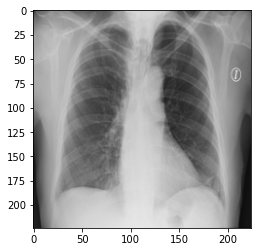

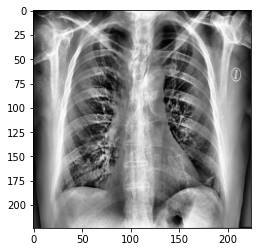

In [ ]:
w = random.randrange(0, 100)
print(w)

plt.imshow(images_test_original[w])
plt.show()
plt.imshow(images_test_clahe[w])
plt.show()

In [ ]:
def testing(images, labels, model, pretrained):
  X_test, y_test = images / 255.0, labels

  X_test_extract = model.predict(X_test)
  X_test_features = X_test_extract.reshape(X_test_extract.shape[0], -1)

  clf = pickle.load(open(pretrained, "rb"))

  prediction = clf.predict(X_test_features)

  a = accuracy_score(y_test, prediction)
  p = precision_score(y_test, prediction)
  r = recall_score(y_test, prediction)
  f = f1_score(y_test, prediction)

  print('acc: ', a)
  print('precision: ', p)
  print('recall: ', r)
  print('f1: ', f)

  prediction_proba = clf.predict_proba(X_test_features)[:, 1]
  auc_score = roc_auc_score(y_test, prediction_proba)

  print('auc: ', auc_score)

In [ ]:
testing(images_test_original, labels_test_original, inceptionv3, "Thesis/trained models/original_inception_v3_SVC(kernel='linear', probability=True)")
testing(images_test_clahe, labels_test_clahe, inceptionv3, "Thesis/trained models/original_inception_v3_SVC(kernel='linear', probability=True)")

12/12 [==============================] - 9s 731ms/step
acc:  0.5561643835616439
precision:  0.677570093457944
recall:  0.6092436974789915
f1:  0.6415929203539823
auc:  0.5773506252894859
12/12 [==============================] - 8s 667ms/step
acc:  0.6602739726027397
precision:  0.7435897435897436
recall:  0.7310924369747899
f1:  0.7372881355932203
auc:  0.7084298286243631


In [ ]:
testing(images_test_original, labels_test_original, resnet50, "Thesis/trained models/original_resnet50_SVC(kernel='linear', probability=True)")
testing(images_test_clahe, labels_test_clahe, resnet50, "Thesis/trained models/clahe_resnet50_SVC(kernel='linear', probability=True)")

12/12 [==============================] - 16s 1s/step
acc:  0.7561643835616438
precision:  0.7709090909090909
recall:  0.8907563025210085
f1:  0.8265107212475634
auc:  0.8486402434989745
12/12 [==============================] - 16s 1s/step
acc:  0.7616438356164383
precision:  0.8007968127490039
recall:  0.8445378151260504
f1:  0.8220858895705522
auc:  0.8406338913518163


In [ ]:
testing(images_test_original, labels_test_original, resnet50, "Thesis/trained models/original_resnet50_SVC(probability=True)")
testing(images_test_clahe, labels_test_clahe, resnet50, "Thesis/trained models/clahe_resnet50_SVC(probability=True)")

12/12 [==============================] - 16s 1s/step
acc:  0.7808219178082192
precision:  0.7743055555555556
recall:  0.9369747899159664
f1:  0.8479087452471483
auc:  0.9111361079865016
12/12 [==============================] - 16s 1s/step
acc:  0.8547945205479452
precision:  0.8517110266159695
recall:  0.9411764705882353
f1:  0.8942115768463074
auc:  0.9380996493085424


In [ ]:
# applying clahe to several existing hybrid models from previous publications can improve their performances.

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(np.array(images_original)/255.0, np.array(labels_original), test_size=0.30, random_state=101)

In [ ]:
def get_model():

    #Input shape = [width, height, color channels]
    inputs = layers.Input(shape=(SIZE, SIZE, 3))

    # Block One
    x = layers.Conv2D(filters=16, kernel_size=3, padding='valid')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPool2D()(x)
    x = layers.Dropout(0.2)(x)

    # Block Two
    x = layers.Conv2D(filters=32, kernel_size=3, padding='valid')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPool2D()(x)
    x = layers.Dropout(0.2)(x)

    # Block Three
    x = layers.Conv2D(filters=64, kernel_size=3, padding='valid')(x)
    x = layers.Conv2D(filters=64, kernel_size=3, padding='valid')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPool2D()(x)
    x = layers.Dropout(0.4)(x)

    # Head
    #x = layers.BatchNormalization()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.5)(x)

    #Final Layer (Output)
    output = layers.Dense(1, activation='sigmoid')(x)

    model = keras.Model(inputs=[inputs], outputs=output)

    return model

In [ ]:
model = get_model()
model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=3e-5), metrics='binary_accuracy')

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 222, 222, 16)     64        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 222, 222, 16)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 16)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 111, 111, 16)      0     

In [ ]:
model.fit(x=X_train,
          y=y_train,
          epochs=20,
          validation_data=(X_test, y_test), verbose=1
          )

Epoch 1/20
19/19 [==============================] - 17s 808ms/step - loss: 0.8641 - binary_accuracy: 0.5386 - val_loss: 0.6937 - val_binary_accuracy: 0.4766
Epoch 2/20
19/19 [==============================] - 14s 749ms/step - loss: 0.7022 - binary_accuracy: 0.5738 - val_loss: 0.6933 - val_binary_accuracy: 0.4766
Epoch 3/20
19/19 [==============================] - 14s 762ms/step - loss: 0.6653 - binary_accuracy: 0.6174 - val_loss: 0.6940 - val_binary_accuracy: 0.4766
Epoch 4/20
19/19 [==============================] - 14s 743ms/step - loss: 0.6652 - binary_accuracy: 0.5856 - val_loss: 0.6943 - val_binary_accuracy: 0.4766
Epoch 5/20
19/19 [==============================] - 14s 758ms/step - loss: 0.6679 - binary_accuracy: 0.5872 - val_loss: 0.6993 - val_binary_accuracy: 0.4766
Epoch 6/20
19/19 [==============================] - 14s 750ms/step - loss: 0.6427 - binary_accuracy: 0.6023 - val_loss: 0.7027 - val_binary_accuracy: 0.4766
Epoch 7/20
19/19 [==============================] - 14s 75

<AxesSubplot:>

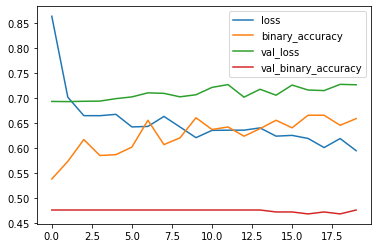

In [ ]:
model_loss = pd.DataFrame(model.history.history)
model_loss.plot()

In [ ]:
# using cnn from scratch results in poor performances, most important one is val_loss which goes up that indicates overfitting

In [ ]:
base_model = densenet121
base_model.trainable = False

def get_pretrained():

    #Input shape = [width, height, color channels]
    inputs = layers.Input(shape=(SIZE, SIZE, 3))

    x = base_model(inputs)

    # Head
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.1)(x)

    #Final Layer (Output)
    output = layers.Dense(1, activation='sigmoid')(x)

    model = keras.Model(inputs=[inputs], outputs=output)

    return model

In [ ]:
model_pretrained = get_pretrained()
model_pretrained.compile(loss='binary_crossentropy', optimizer = keras.optimizers.Adam(learning_rate=5e-5), metrics='binary_accuracy')

model_pretrained.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_21 (Dense)            (None, 128)               131200    
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_22 (Dense)            (None, 1)                 129       
                                                           

In [ ]:
model_pretrained.fit(x=X_train,
          y=y_train,
          epochs=20,
          validation_data=(X_test, y_test), verbose=1
          )

Epoch 1/20
19/19 [==============================] - 46s 2s/step - loss: 0.6985 - binary_accuracy: 0.5067 - val_loss: 0.6779 - val_binary_accuracy: 0.5977
Epoch 2/20
19/19 [==============================] - 36s 2s/step - loss: 0.6797 - binary_accuracy: 0.5872 - val_loss: 0.6686 - val_binary_accuracy: 0.6992
Epoch 3/20
19/19 [==============================] - 35s 2s/step - loss: 0.6652 - binary_accuracy: 0.6376 - val_loss: 0.6546 - val_binary_accuracy: 0.7305
Epoch 4/20
19/19 [==============================] - 36s 2s/step - loss: 0.6523 - binary_accuracy: 0.6728 - val_loss: 0.6481 - val_binary_accuracy: 0.7227
Epoch 5/20
19/19 [==============================] - 36s 2s/step - loss: 0.6484 - binary_accuracy: 0.6779 - val_loss: 0.6430 - val_binary_accuracy: 0.7305
Epoch 6/20
19/19 [==============================] - 36s 2s/step - loss: 0.6442 - binary_accuracy: 0.6779 - val_loss: 0.6371 - val_binary_accuracy: 0.7344
Epoch 7/20
19/19 [==============================] - 36s 2s/step - loss: 0.63

<AxesSubplot:>

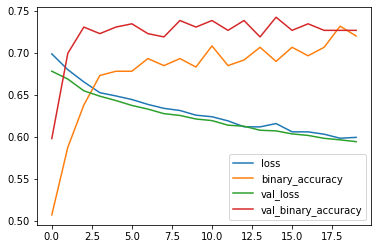

In [ ]:
model_loss = pd.DataFrame(model_pretrained.history.history)
model_loss.plot()